<a href="https://colab.research.google.com/github/seraffin/FailOmen/blob/master/Wojtek/NNOptimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
# import keras

# Helper libraries
import matplotlib.pyplot as plt

from scipy.optimize import minimize

In [0]:
def returnStepList(minValue, maxValue, nrSteps):
    step = math.fabs(maxValue - minValue)/nrSteps
    actualMin = min([minValue, maxValue])
    actualMax = max([minValue, maxValue])
    
    
    return [actualMin + step*nr for nr in range(nrSteps + 1)]

In [24]:
returnStepList(0.004,0.04,8)

[0.004,
 0.0085,
 0.013000000000000001,
 0.0175,
 0.022000000000000002,
 0.026500000000000003,
 0.031000000000000003,
 0.035500000000000004,
 0.04000000000000001]

In [0]:
plotData = []
iterationCounter = 0
recurencyCounter = 0
bestResult = None


def optimize(minMax1, minMax2, steps, split = 4, reduceSplit = False):
    global iterationCounter
    global recurencyCounter
    global bestResult
    
    if reduceSplit is False:
      newSplit = split
    else:
      if split > 2:
        newSplit = split - 1
      else:
        newSplit = 2
    if split > 10:
      raise ValueError("Too big value of 'split' parameter! This would highly increase number of iterations")
    recurencyCounter += 1
#     try:
    if True:
        if isinstance(minMax1, list) and isinstance(minMax1, list) and len(minMax1) == len(minMax2) == 2:
            
            stepList1 = returnStepList(minMax1[0], minMax1[1], split)
            stepList2 = returnStepList(minMax2[0], minMax2[1], split)
            i1 = 0
            i2 = 0
            
            resultList = []
            parametersList=[]
            
            
            bestPair = [None, None]
            for el1 in stepList1:
                i2 = 0
                for el2 in stepList2:
                    iterationCounter += 1
                    print("el1: {0}\nel2: {1}\n".format(el1, el2))
                    
                    
                    #----function----
                    evaluation = el1+el2
                    #----function----
                    
                    
                    
                    if len(resultList) > 0:
                        
                        #----condition----
                        if evaluation >= max(resultList):
                            bestPair[0] = i1
                            bestPair[1] = i2
                        
                        #----condition----
                    else:
                        bestPair[0] = i1
                        bestPair[1] = i2
                    
                    plotData.append([evaluation, iterationCounter])

                    resultList.append(evaluation)
                    parametersList.append([el1, el2])
                    i2 += 1
                print("----------------------------------------------")
                i1 += 1

            #------------------------------------------------
            
            
            if bestPair[0] == stepList1.index(stepList1[0]):
                minMax1[0] = stepList1[bestPair[0]]/2
                minMax1[1] = stepList1[bestPair[0] + 1]
                print("best values of PARAM_1 are close to MIN value")
                
            elif bestPair[0] == stepList1.index(stepList1[-1]):
                minMax1[0] = stepList1[bestPair[0] - 1]
                minMax1[1] = stepList1[bestPair[0]]*2
                print("best values of PARAM_1 are close to MAX value")

                
            else:
                minMax1[0] = stepList1[bestPair[0] - 1]
                minMax1[1] = stepList1[bestPair[0] + 1]
            
            #------------------------------------------------
            
            if bestPair[1] == stepList2.index(stepList2[0]):
                minMax2[0] = stepList1[bestPair[0]]/2
                minMax2[1] = stepList1[bestPair[0] + 1]
                print("best values of PARAM_2 are close to MIN value")
                
            elif bestPair[1] == stepList2.index(stepList2[-1]):
                minMax2[0] = stepList1[bestPair[0] - 1]
                minMax2[1] = stepList1[bestPair[0]]*2
                print("best values of PARAM_2 are close to MAX value")

                
            else:
                minMax2[0] = stepList2[bestPair[1] - 1]
                minMax2[1] = stepList2[bestPair[1] + 1]
                
            #------------------------------------------------
            
            
            result = max(resultList)
            param1 = parametersList[resultList.index(max(resultList))][0]
            param2 = parametersList[resultList.index(max(resultList))][1]

            print()
            if steps > 0:
                print("new iteration loop")
                optimize([minMax1[0], minMax1[1]], [minMax2[0], minMax2[1]], steps - 1, newSplit)
            else:
                print("result list:\n{}".format([result, param1, param2]))
                return [result, param1, param2]
            
            

        else:
            print("enter correct value!")
#     except:
#         print("---ERROR---")

In [0]:
def searchForFailed(yList):
    changedRowList = []
    for row in range (len(yList)):
        if 0 in yList[row]:
            changedRowList.append(row)
    return changedRowList

def returnFailedData(xList, yList, changedRowList):
    xFailed = []
    yFailed = []
  
    for row in changedRowList:
        xFailed.append(xList[row])
        yFailed.append(yList[row])
    xFailed = np.array(xFailed)
    yFailed = np.array(yFailed)
    return xFailed, yFailed



In [0]:
def count_distribution(prediction):
    #Distributions of argmins through all the predictions
    i = 1
    tab = [0] * 542
    for a in prediction:
        j = 0
        for b in a:
            if b < 1.0 : j = j + 1

        #print (i, '. ', j, np.argmin(a))
        tab[np.argmin(a)] += 1
        i = i + 1

    i = 0
    distributed_array = []
    for a in tab:
        if a > 0 : 
            #print ('position', i, '\targmin count', a)
            distributed_array.append((i,a))
        i += 1
    create_plot(distributed_array)  
    return distributed_array


In [0]:
def create_plot(x_data, y_data=0, xLabel = 'X', yLabel = 'Y'):
    import matplotlib.pyplot as plt
    if y_data == 0:  
        unzip = list(zip(*x_data))
        x_data, y_data = unzip[0],unzip[1]
    plt.plot(x_data, y_data)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.show()

In [0]:
def failsCount():
    fala = 0
    for i, a in enumerate(yTest):
        j = 0
        for k, b in enumerate(a):
            if b < 1.0 : j += 1

        if j > 0 : 
            print (i, '. ', j)
        i = i + 1
        fala += j
    print (fala)

In [0]:
# Evaluation function

def evaluation(additionalPredictions, refYsupervisor, predictions):

    lenght = len(refYsupervisor)

    failPositions = [[] for y in range(lenght)]

  
    for i, a in enumerate(refYsupervisor):

        for j, b in enumerate(a):
            if b == 0 : failPositions[i].append(j);

    predictionsTemp = predictions.copy()
    predictionPositions = [[] for y in range(lenght)]


    for i, a in enumerate(predictionsTemp):

        if len(failPositions[i]) != 0:
            for j in range(len(failPositions[i]) + additionalPredictions):
                argmin = np.argmin(a)
                predictionPositions[i].append(argmin)
                predictionsTemp[i][argmin] = 1

    predictionHits = [[] for y in range(lenght)]

    for i, a in enumerate(failPositions):
        count = 0
        for j, b in enumerate(a):


            for c in predictionPositions[i]:
  #      predictionHits[i].append(predictions[i][c].copy())
  #      print(predictions[i][c])
  #      print(predictions[i][c])
  #      print (b, c)
                if c == b : count += 1

        if len(failPositions) != 0:
            predictionHits[i].insert(0,count)


    failsCount = 0
    hitsCount = 0
    for i, a in enumerate(refYsupervisor):
        j = 0

        for k, b in enumerate(a):
            if b < 1.0 : j += 1

  #  if j > 0 :
  #    print (i, '.', j, predictionHits[i])


        failsCount += j
        hitsCount += predictionHits[i][0]
    
    percFailsPredicted = hitsCount / failsCount * 100
    print('Percentage of fails predicted', hitsCount / failsCount * 100, '%')
    return percFailsPredicted

el1: 1.0
el2: 20.0

el1: 1.0
el2: 27.5

el1: 1.0
el2: 35.0

el1: 1.0
el2: 42.5

el1: 1.0
el2: 50.0

el1: 1.0
el2: 57.5

el1: 1.0
el2: 65.0

el1: 1.0
el2: 72.5

el1: 1.0
el2: 80.0

----------------------------------------------
el1: 13.375
el2: 20.0

el1: 13.375
el2: 27.5

el1: 13.375
el2: 35.0

el1: 13.375
el2: 42.5

el1: 13.375
el2: 50.0

el1: 13.375
el2: 57.5

el1: 13.375
el2: 65.0

el1: 13.375
el2: 72.5

el1: 13.375
el2: 80.0

----------------------------------------------
el1: 25.75
el2: 20.0

el1: 25.75
el2: 27.5

el1: 25.75
el2: 35.0

el1: 25.75
el2: 42.5

el1: 25.75
el2: 50.0

el1: 25.75
el2: 57.5

el1: 25.75
el2: 65.0

el1: 25.75
el2: 72.5

el1: 25.75
el2: 80.0

----------------------------------------------
el1: 38.125
el2: 20.0

el1: 38.125
el2: 27.5

el1: 38.125
el2: 35.0

el1: 38.125
el2: 42.5

el1: 38.125
el2: 50.0

el1: 38.125
el2: 57.5

el1: 38.125
el2: 65.0

el1: 38.125
el2: 72.5

el1: 38.125
el2: 80.0

----------------------------------------------
el1: 50.5
el2: 20.0


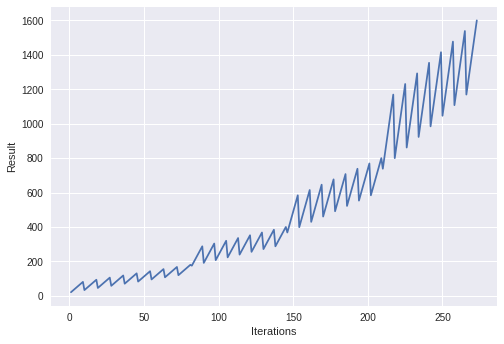

In [87]:
plotData = []
iterationCounter = 0
optimize([1,100], [20, 80], 3 , 8, reduceSplit = True)
xData = [num[1] for num in plotData]
yData = [num[0] for num in plotData]

create_plot(xData, yData, 'Iterations', 'Result')

In [0]:
#Importing dataset
dataset = pd.read_csv('dataToML_newConcept.csv', index_col=False)

#Check the first 5 rows of the dataset. 
dataset.head(5)

In [0]:
x = dataset.iloc[:, 0:23739].values
y = dataset.iloc[:, 23739:24281].values

In [0]:
xReduced, yReduced = returnFailedData(x, y, searchForFailed(y))

In [0]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(xReduced, yReduced, test_size = 0.2)


In [0]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

# Adding the input layer and the output layer
model.add(Dense(units = 542, activation="sigmoid", input_dim=23739, kernel_initializer="uniform")) # TRY smaller input_dim value or less neurons

In [0]:
model.compile(optimizer = tf.train.MomentumOptimizer(learning_rate = 0.01, momentum = 0.4), loss = 'binary_crossentropy', metrics = ['accuracy'])
 
model.fit(xTrain, yTrain, batch_size = 10, epochs = 2)

In [0]:
predictionArray = []



def constraint_1(x):
    result = 9000 - x[0] - x[1] - x[2]
    return result

def calculateNetwork(x):
    inputUnits = int(x[0])
    firstLayerUnits = int(x[1])
    secondLayerUnits = int(x[2])
    if not isinstance(inputUnits, (int)) or not isinstance(firstLayerUnits, (int)) or not isinstance(secondLayerUnits, (int)):
        print("Enter correct input!")\

    else:
        
        
        pBatchSize = 10
        pEpochs = 1
        pLearningRate = 0.01
        pMomentum = 0.04
  
        model = Sequential()

        # Adding the input layer and the first hidden layer
        model.add(Dense(inputUnits, activation="sigmoid", input_dim=23739, kernel_initializer="uniform")) # TRY smaller input_dim value or less neurons
        # Adding the second hidden layer
        model.add(Dense(firstLayerUnits, activation = "sigmoid", kernel_initializer="uniform"))
        # Adding the output layer
        model.add(Dense(secondLayerUnits, activation="sigmoid", kernel_initializer="uniform"))
  
  
        model.compile(optimizer = tf.train.MomentumOptimizer(learning_rate = pLearningRate, momentum = pMomentum), loss = 'binary_crossentropy', metrics = ['accuracy'])
        model.fit(xTrain, yTrain, batch_size = pBatchSize, epochs = pEpochs)
  
        predictions = model.predict(xReduced)
        evaluationResult = evaluation(15, yReduced, predictions)
        predictionArray.append(evaluationResult)
        return 100 - evaluationResult
    
x0 = [3000, 3000, 3000]
a = (1000, 9000)
b = (100, 542)
bnds = (a,a,b)
con1 = {'type': 'ineq' , 'fun': constraint_1}
cons = [con1]

In [0]:
for i in range(1, 2):
    pBatchSize = 10
    pEpochs = 2
    pLearningRate = 0.01
    pMomentum = 0.01
    
    print(calculateNetwork([6070, 3000, 400]))
    print("\n ----------------------------------------------------------\n")

print(predictionArray)
#     model = Sequential()

  
  
#     # Adding the input layer and the first hidden layer
#     model.add(Dense(6070, activation="sigmoid", input_dim=23739, kernel_initializer="uniform")) # TRY smaller input_dim value or less neurons
#     # Adding the second hidden layer
#     model.add(Dense(2000 * i, activation = "sigmoid", kernel_initializer="uniform"))
#     # Adding the output layer
#     model.add(Dense(542, activation="sigmoid", kernel_initializer="uniform"))
  
  
#     model.compile(optimizer = tf.train.MomentumOptimizer(learning_rate = pLearningRate, momentum = pMomentum), loss = 'binary_crossentropy', metrics = ['accuracy'])
#     model.fit(xTrain, yTrain, batch_size = pBatchSize, epochs = pEpochs)
  
#     predictions = model.predict(xReduced)
  
#     predictionArray.append(evaluation(15, yReduced))
    